# PyMC Tutorial

* PyMC is a python module that implements ***Bayesian statistical models*** and fitting algorithms, including ***Markov chain Monte Carlo***. 
* Along with core sampling functionality, PyMC includes methods for summarizing output, plotting, goodness-of-fit and convergence diagnostics.

# Comparison with other packages

|                  | **Other Packages**           | **PyMC**  |
| -----------------|:-----------------------------| :---------|
| **Package type** |BUGS is a standalone package  |<li> Dependent on other highly optimized python packages </li> <li>Can take advantage of other powerful python data and viz libraries</li>|
| **Development**  |<li>Few developers working on it</li> <li>Pseudo open source [(very hard to develop)](http://geospaced.blogspot.com/2013/04/why-you-should-not-use-winbugs-or.html) </li>   |   Open source|

    

In [2]:
%matplotlib inline
import numpy as np  
import pandas as pd  
import seaborn as sns  
sns.set(style="darkgrid", palette="muted")  
rndst = np.random.RandomState(0)


# Fuction to generate random data 
 
Create a toy dataset based on a very simple model that we might imagine is a noisy physical process

Model form: 
    
   

$$y \mathtt{\sim} a + bx + cx^2 + e$$

* a: Intercept
* b: Linear coefficient
* c: Quadratic coefficient
* e: Latent error

In [3]:
def generate_data(n=25, a=1, b=1, c=0, latent_error_y=1):  

    ## create linear or quadratic model
    df = pd.DataFrame({'x':rndst.choice(np.arange(100),n,replace=False)})
    df['y'] = a + b*(df['x']) + c*(df['x'])**2 

    ## add latent error noise
    df['y'] += rndst.normal(0,latent_error_y,n)

    return df

# Linear Model

### Generating simple linear model

$$y∼a+bx+cx^{2}+e$$ 
$$a = 5$$
$$b = 2$$
$$e = 15$$

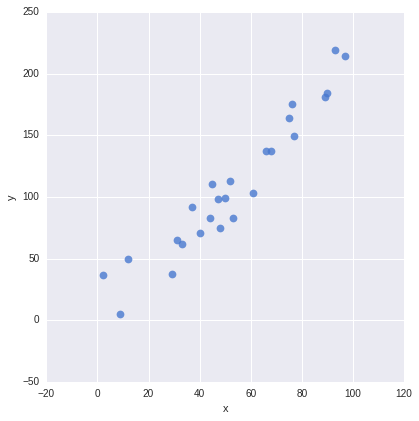

In [21]:
a, b, c, e = 5, 2, 0, 15 

df = generate_data(a=a, b=b, latent_error_y=e)

y = lambda x: a + b*x + c*x**2
x = np.linspace(0, 100)

g = sns.lmplot(x='x', y='y', data=df, fit_reg=False  
               ,size=6, scatter_kws={'alpha':0.8, 's':60})

## NOTE: `lmplot()` will fit and plot a lin. reg. line by default. 
## Not used here, but can greatly help data exploration in practice.

### Fitting an Ordinary Least Square Regression

In [52]:
import patsy as pt  
import statsmodels.api as sm

## first, encode model specification as design matrices
fml = 'y ~ 1 + x'  
(mx_en, mx_ex) = pt.dmatrices(fml, df, return_type='dataframe'
                              ,NA_action='raise')

## fit OLS model and print results
smfit = sm.OLS(endog=mx_en, exog=mx_ex, hasconst=True).fit()  
print(smfit.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     124.4
Date:                Sun, 17 Apr 2016   Prob (F-statistic):           9.37e-11
Time:                        22:35:32   Log-Likelihood:                -117.08
No. Observations:                  25   AIC:                             238.2
Df Residuals:                      23   BIC:                             240.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -4.7427     10.503     -0.452      0.6

### Vizualizing

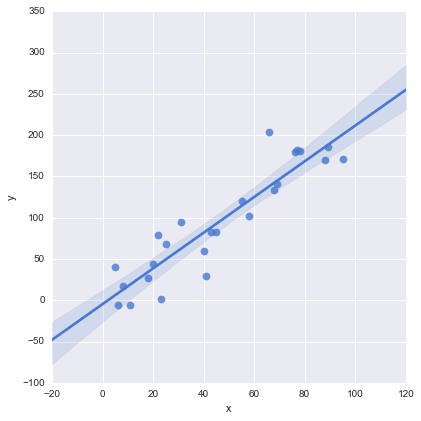

In [55]:
sns.lmplot(x='x', y='y', data=df, fit_reg=True,size=6, scatter_kws={'alpha':0.8, 's':60})

# Generalized Linear Model using PyMC

The Maximum A Posteriori (MAP) was found using Powell Optimization which is basically 
>*An efficient method for finding the minimum of a function of several variables without calculating derivatives*

$$f = \frac{1}{1+(x-y)^2}+ \sin(\frac12 \pi yz) + \exp(-(\frac{x+z}{y}-2)^2)$$

Uses NUTS (No U Turn Sampling) for sampling 
>*a self-tuning variant of Hamiltonian Monte Carlo*

Fitting a generalized linear model in PyMC is a one line task.

In [50]:
import pymc3 as pm  
from scipy.optimize import fmin_powell

with pm.Model() as mdl_ols:

    ## Use GLM submodule for simplified patsy-like model spec
    ## Use Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df, family=pm.glm.families.Normal())

    ## find MAP using Powell optimization
    start_MAP = pm.find_MAP(fmin=fmin_powell)

    ## take samples using NUTS
    trc_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS())

Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 3.1 sec

### Vizualizing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b646810>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115a9c110>]], dtype=object)

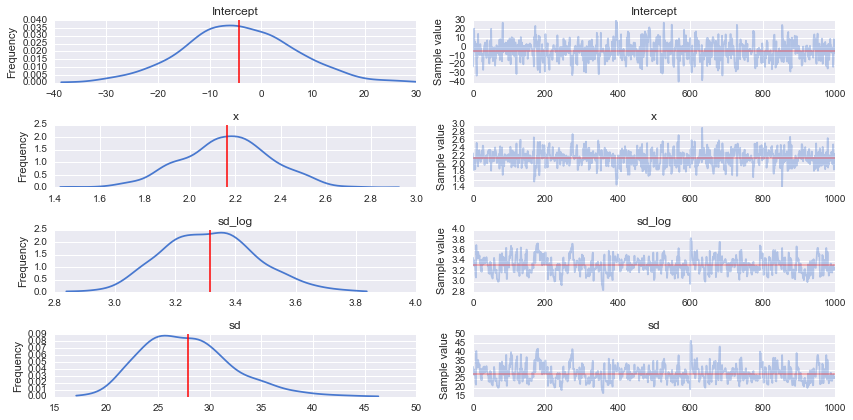

In [51]:
pm.traceplot(trc_ols[-1000:], figsize=(12,len(trc_ols.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trc_ols[-1000:]).iterrows()})

### Summary of results

In [53]:
pm.summary(trc_ols[-1000:])


Intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -4.337           10.797           0.459            [-26.370, 15.898]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -25.794        -11.289        -4.457         2.710          17.303


x:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.161            0.200            0.009            [1.797, 2.547]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.753          2.033          2.167          2.291          2.534


sd_log:

  Mean             SD               MC Error         95% HPD interval
  --------------------

### A smaller summary.. 

In [54]:
pm.df_summary(trc_ols[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,-4.336661,10.796971,0.459415,-26.370033,15.898144
x,2.161121,0.199535,0.008707,1.797325,2.546954
sd_log,3.316000,0.157463,0.009962,3.026760,3.629100
sd,27.897524,4.495339,0.286289,20.054126,36.761082


In [ ]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['sd']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(mdl_ols, trc_ols, df, xlims)
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2)

Fitting a different distribution is as easy as changing the family of functions

In [6]:
import pymc3 as pm  
from scipy.optimize import fmin_powell

with pm.Model() as mdl_ols:

    ## Use GLM submodule for simplified patsy-like model spec
    ## Use Normal likelihood (which uses HalfCauchy for error prior)
    pm.glm.glm('y ~ 1 + x', df, family=pm.glm.families.StudentT())

    ## find MAP using Powell optimization
    start_MAP = pm.find_MAP(fmin=fmin_powell)

    ## take samples using NUTS
    trc_ols = pm.sample(2000, start=start_MAP, step=pm.NUTS())

Applied log-transform to lam and added transformed lam_log to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 3.4 sec

In [10]:
pm.df_summary(trc_ols[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
Intercept,10.188661,6.891749,0.489818,-3.874317,23.698112
x,1.878374,0.120033,0.007211,1.668126,2.136522
lam_log,-4.961337,0.560603,0.019122,-5.968022,-3.807702
lam,0.008199,0.004921,0.000173,0.001396,0.018405


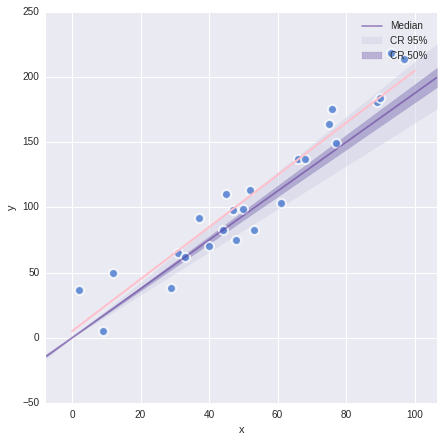

In [23]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['Intercept','x']]
    trc_sd = pm.trace_to_dataframe(trc)['lam']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(mdl_ols, trc_ols, df, xlims)
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2)

The same thing can be done in a more traditional way as is done in WinBugs. This can be used for more complex functions.

In [57]:
trace = None
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    y_est = alpha + beta * df['x']
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=df['y'])
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=False)

Applied interval-transform to sigma and added transformed sigma_interval to model.


 In general, we can fit any function for y_est and it will fit the parameters accordingly.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bda3750>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1179e3d90>]], dtype=object)

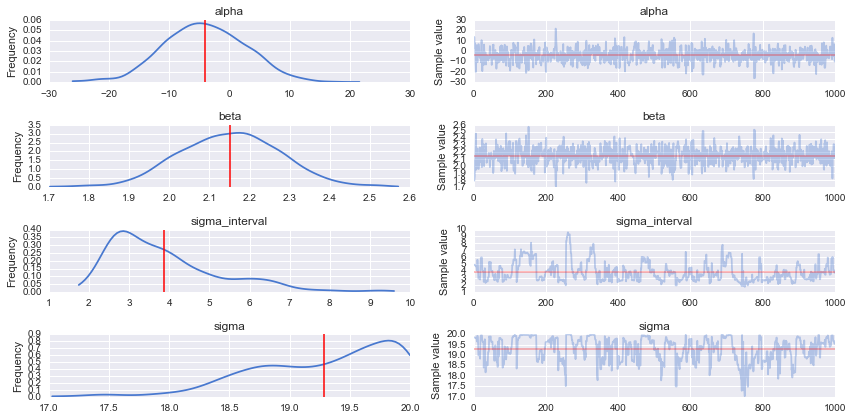

In [58]:
pm.traceplot(trace[-1000:], figsize=(12,len(trace.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()})

In [59]:
pm.df_summary(trace[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-4.074168,6.830584,0.284288,-16.247075,9.428037
beta,2.151875,0.127131,0.005281,1.924858,2.411463
sigma_interval,3.864238,1.390306,0.113611,2.084980,6.769998
sigma,19.284035,0.583706,0.045271,18.286297,19.998645


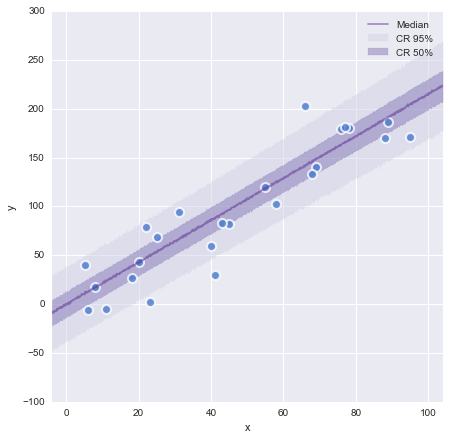

In [60]:
import matplotlib.pyplot as plt

def plot_posterior_cr(mdl, trc, rawdata, xlims, npoints=1000):  
    '''
    Convenience fn: plot the posterior predictions from mdl given trcs
    '''

    ## extract traces
    trc_mu = pm.trace_to_dataframe(trc)[['alpha','beta']]
    trc_sd = pm.trace_to_dataframe(trc)['sigma']

    ## recreate the likelihood
    x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
    X = x ** np.ones((npoints,2)) * np.arange(2)
    like_mu = np.dot(X,trc_mu.T)
    like_sd = np.tile(trc_sd.T,(npoints,1))
    like = np.random.normal(like_mu, like_sd)

    ## Calculate credible regions and plot over the datapoints
    dfp = pd.DataFrame(np.percentile(like,[2.5, 25, 50, 75, 97.5], axis=1).T
                         ,columns=['025','250','500','750','975'])
    dfp['x'] = x

    pal = sns.color_palette('Purples')
    f, ax1d = plt.subplots(1,1, figsize=(7,7))
    ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
                      ,color=pal[1], label='CR 95%')
    ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.4
                      ,color=pal[4], label='CR 50%')
    ax1d.plot(dfp['x'], dfp['500'], alpha=0.5, color=pal[5], label='Median')
    _ = plt.legend()
    _ = ax1d.set_xlim(xlims)
    _ = sns.regplot(x='x', y='y', data=rawdata, fit_reg=False
            ,scatter_kws={'alpha':0.8,'s':80, 'lw':2,'edgecolor':'w'}, ax=ax1d)

xlims = (df['x'].min() - np.ptp(df['x'])/10, df['x'].max() + np.ptp(df['x'])/10)

plot_posterior_cr(model, trace, df, xlims)
plt.plot(x, y(x), color='pink', linestyle='-', linewidth=2)

In [61]:
trace = None
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    mewmew = pm.Normal('mewmew', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=20)
    
    y_est = alpha + beta * df['x'] + mewmew * df['x'] * df['x']
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=df['y'])
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(2000, step, start=start, progressbar=False)

Applied interval-transform to sigma and added transformed sigma_interval to model.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a35ab90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12b9a13d0>]], dtype=object)

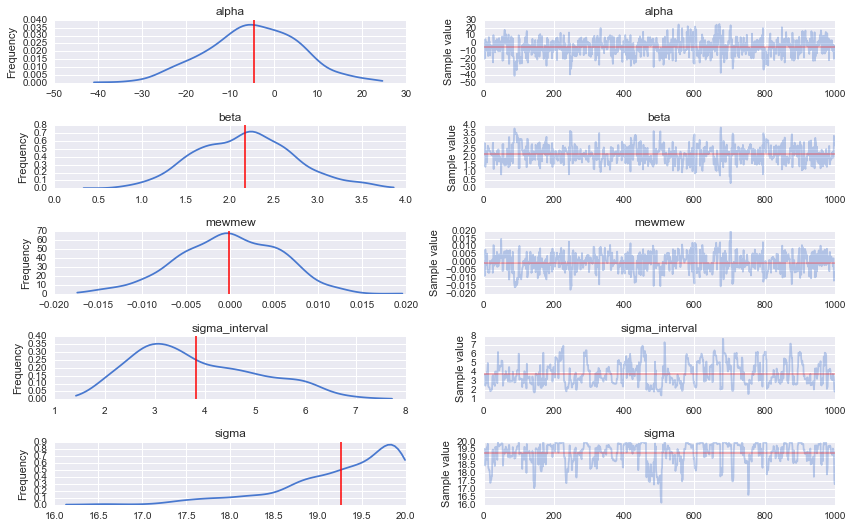

In [62]:
pm.traceplot(trace[-1000:], figsize=(12,len(trace.varnames)*1.5),
             lines={k: v['mean'] for k, v in pm.df_summary(trace[-1000:]).iterrows()})

In [63]:
pm.df_summary(trace[-1000:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,-4.673878,10.672447,0.509867,-25.958418,15.691773
beta,2.173595,0.559561,0.029096,1.084068,3.278620
mewmew,-0.000136,0.005774,0.000298,-0.011316,0.011049
sigma_interval,3.822600,1.239006,0.093654,1.891776,6.170375
sigma,19.266738,0.677682,0.050000,17.800405,19.991175


In [64]:
import matplotlib.pyplot as plt
import numpy as np 
def graph(formula, x_range, color='black', alpha=1):  
    x = np.array(x_range)  
    y = eval(formula)
    plt.plot(x, y, color=color, alpha=alpha)

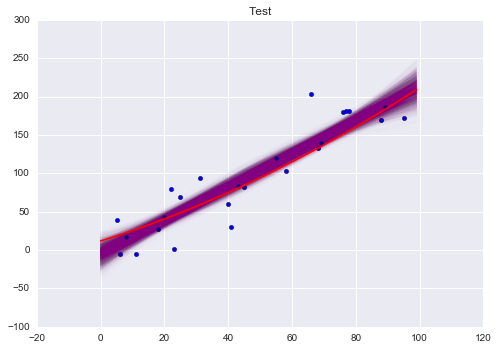

In [65]:
plt.scatter(df['x'],df['y'])

for i in range(0,2000):
    point = trace.point(i)
    graph('{0} + {1}*x + {2}*x*x'.format(point['alpha'], point['beta'], point['mewmew']), range(0,100), color='purple', alpha=.00908035)

graph('11.9 + 1.3*x + .007*x*x', range(0,100), color='red', alpha=1)
plt.plot([0, 100], [y(0), y(100)], color='pink', linestyle='-', linewidth=2)
plt.title('Test')
plt.show()
